#### Load required modules

In [1]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SHWFS_ES'

In [116]:
# Reload DOS library
import importlib
importlib.reload(dos)


<module 'dos' from '/Users/rromano/Workspace/SIMCEO/dos/__init__.py'>

In [14]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

#### Compute reconstructor from interacion matrix

In [77]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

# Load calibration data 
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM_ES.npz', allow_pickle=True)
# Compute SH-WFS consolidated interaction matrix
Dsh = dos.tools.get_SHWFS_D(dt['calibdt'][()]['D'], includeM1S7Rz_col=True)
n_bm = (Dsh.shape[1] - 82)//7
if((Dsh.shape[1] - 82)%7):
    print('Noninteger result in n_bm computation!')

# Merge SH-WFS and Edge sensor interaction matrix
alphaBM, alphaEs= 1.0, 1.0 # 1.0/40, 10
Dm = dos.tools.merge_SH_ES_D(Dsh, dt['calibdt'][()]['De'], alphaBM=alphaBM, alphaEs=alphaEs)
# Piston nduced by M2 calibration matrix
Pm2 = dt['calibdt'][()]['P2']
P = np.hstack( [np.zeros((Pm2.shape[0],41)), Pm2[:,:-1], np.zeros((Pm2.shape[0],7*n_bm))])
#M = dos.tools.build_RLS_RecM(Dsh, dt['calibdt'][()]['De'], P, rhoP=0*1.0e1, n_r=7)
M = dos.tools.build_RLS_RecM(Dsh, dt['calibdt'][()]['De'], P, rhoP=0*1.0e1, n_r=32)
#M = dos.tools.build_RLS_RecM(Dsh, De=np.empty([0,0]), P=P, rhoP=0*1.0e1, n_r=12)


#M = dos.tools.build_TSVD_RecM(Dsh,  n_r=12)

# Rescale reconstructor based on interaction matrix merge weights
# BMin_weight_vec = np.ones(M.shape[0])
# n_bm, n_es = 46, dt['calibdt'][()]['De'].shape[0]
# BMin_weight_vec[-7*n_bm:] = alphaBM
# s_weight_vec = np.ones(M.shape[1])
# s_weight_vec[-n_es:] = alphaEs
# M = np.dot(np.diag(BMin_weight_vec), M.dot(np.diag(s_weight_vec)))

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):    
    Msimceo = dos.tools.gen_recM_4_SIMCEO(M, dt['calibdt'][()]['wfsMask'])
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    # dos.tools.linear_estimator_2_dos(np.eye(Msimceo.shape[0]),sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')
    print('SIMCEO reconstructor matrix dimensions:', Msimceo.shape)

Consolidated WFS-SH Interaction matrix is 7360 x 404
Regularization term coefficients:
 [1.67846527e-04 2.38201472e-04 2.38818533e-04 2.38899732e-04
 2.39889057e-04 2.40124124e-04 2.40722096e-04 3.00673345e-04
 3.00920760e-04 4.37951365e-04 4.42057082e-04 4.44493374e-04
 4.49803530e-04 4.51392763e-04 4.57153423e-04 4.80417160e-04
 4.81061220e-04 4.84457435e-04 4.84679262e-04 4.89730825e-04
 4.90278441e-04 1.56631566e-03 1.61749505e-03 1.68357510e-03
 2.34016611e-02 2.35955950e-02 6.24148336e-02 6.27276720e-02
 8.19375631e-01 8.64578411e-01 9.25631185e-01 1.00000000e+00]
SH-WFS reconstructor matrix pickle file is updated!
SIMCEO reconstructor matrix dimensions: (406, 13872)


In [78]:
M.shape, dt['calibdt'][()]['De'].shape

((406, 7408), (48, 36))

#### Set initial M1/M2 states and generate respective yaml files

In [3]:
# Python code to set simulation states...

# * * * Flag to control if simulation initial state must be updated * * *
updateX0 = True
#
alignM1S7Rz = True

asec2rad = 4.84814e-6
n_bm = 46
k_states = 0.5
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateX0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*(2*np.random.rand(6)-1),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M1_Rz = k_states*40*asec2rad*(2*np.random.rand(7,1)-1)
    x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)

    if(alignM1S7Rz):
        x0_M1_Rz[-1] = 0
    
    m1_x0_dt = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateX0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M2_Tz = k_states*170.0e-6*(2*np.random.rand(7,1)-1)
    x0_M2_Rxy = k_states*3.0*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M2_Rz = k_states*330*asec2rad*(2*np.random.rand(7,1)-1)

    m2_x0_dt = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

In [54]:
with open(Path(sim_folder)/'wfs48.yaml','r') as stream:
        wfs48_dt = yaml.safe_load(stream)
wfs48_dt['source']['magnitude'] = [10,10,10]
with open(Path(sim_folder)/'wfs48.yaml','w') as f:
        y.dump(wfs48_dt, f)

In [55]:
with open(Path(sim_folder)/'AcO_controller.yaml','r') as stream:
        aco_ctrl_dt = yaml.safe_load(stream)
aco_ctrl_dt['System']['parameters']['num'] = [-0.1]
with open(Path(sim_folder)/'AcO_controller.yaml','w') as f:
        y.dump(aco_ctrl_dt, f)

#### Instantiate DOS

In [81]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SHWFS_ES/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: M1_ES
INFO:M1_ES:No inputs!
INFO:M1_ES:New output: deltas
INFO:M1_ES:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New input: edge sensors
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged 

SIMCEO server received: Acknowledging connection from SIMCEO client!


INFO:DOS:Simulation setup for a duration of 50s @ 1Hz (50 steps)!


In [82]:
# Start simulation
sim.start()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP2
INFO:M1_ES:EdgeSensors
INFO:science:OP3
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:M1_ES:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:M1_ES:EdgeSensors deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 30.454490184783936


In [ ]:
sim.push()

In [ ]:
sim.init()

In [ ]:
sim.terminate()

#### Simulation results

In [ ]:
sim.logs.entries.keys(), sim.logs
#sim.logs.entries

Final values:
 WFE: [661.9945907] 
 [0.98647635 0.60321664 1.15392806 2.38822806 1.6945586  1.06693321
 1.52568824] 
PSSn: [1.00000022] 
sum of abs seg piston: 4.208359101198766 
 [-0.51453793 -0.28447178  0.60168975  1.14444322  1.04145829 -0.38387586
 -0.23788228]


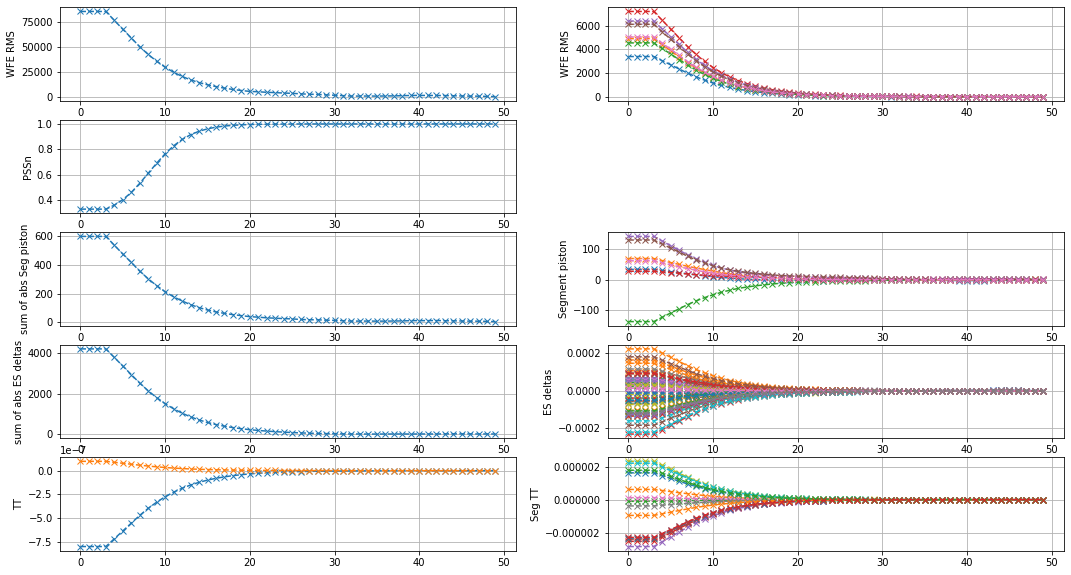

In [83]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

Final values:
 WFE: [1745.01451511] 
 [1.10183696 1.39544243 1.69366066 1.72055303 1.94537675 1.36163791
 0.974824  ] 
PSSn: [0.99999961] 
sum of abs seg piston: 11.583426783090545 
 [ 2.38489315 -1.10178985 -2.0706957  -2.15615319  0.47199188  1.81832297
 -1.57958004]


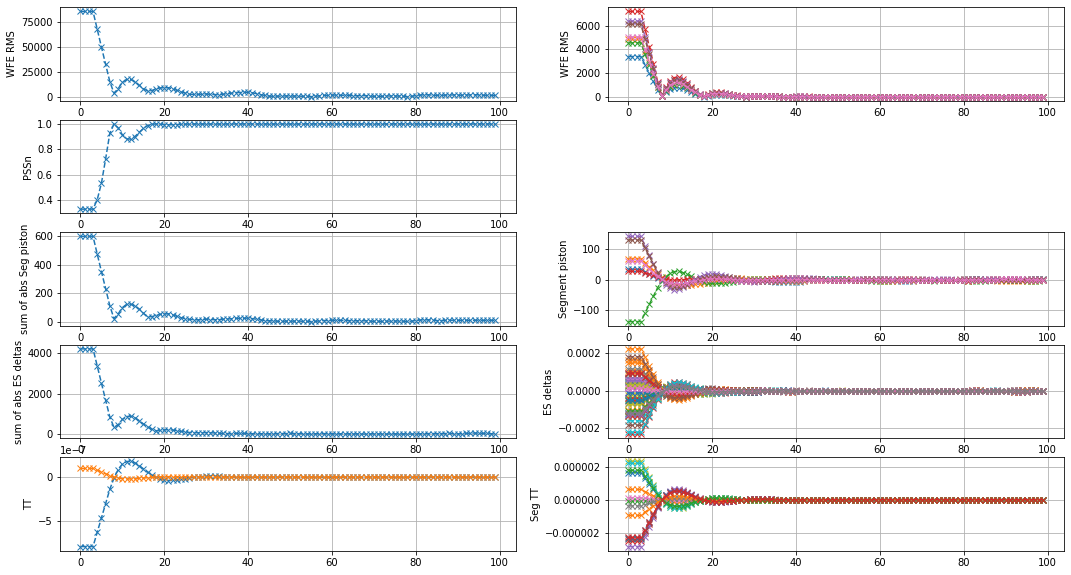

In [19]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

#### Control effort

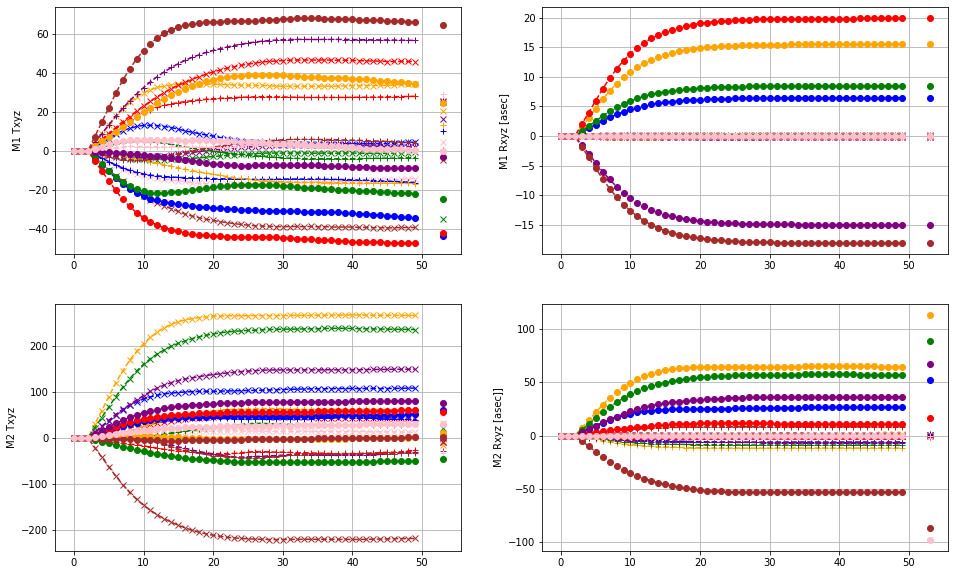

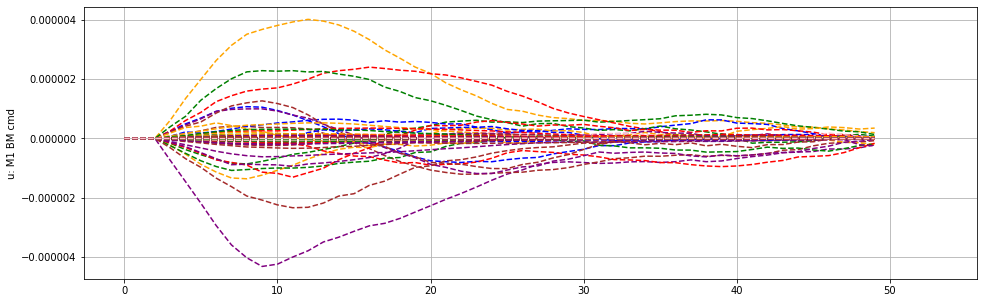

In [84]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Mismatch steady-state

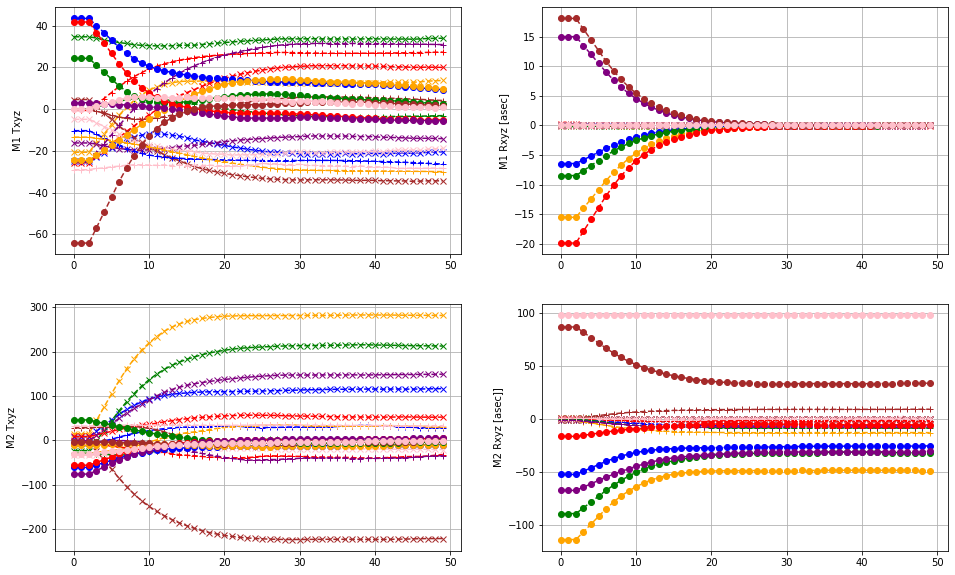

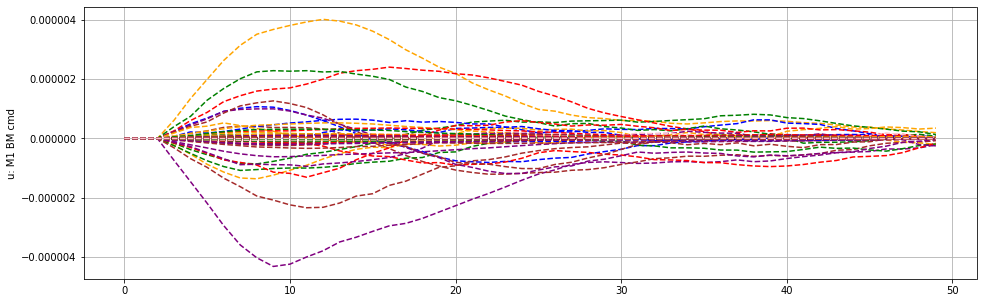

In [85]:
U = sim.logs.entries['AcO_controller']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Reconstructed states

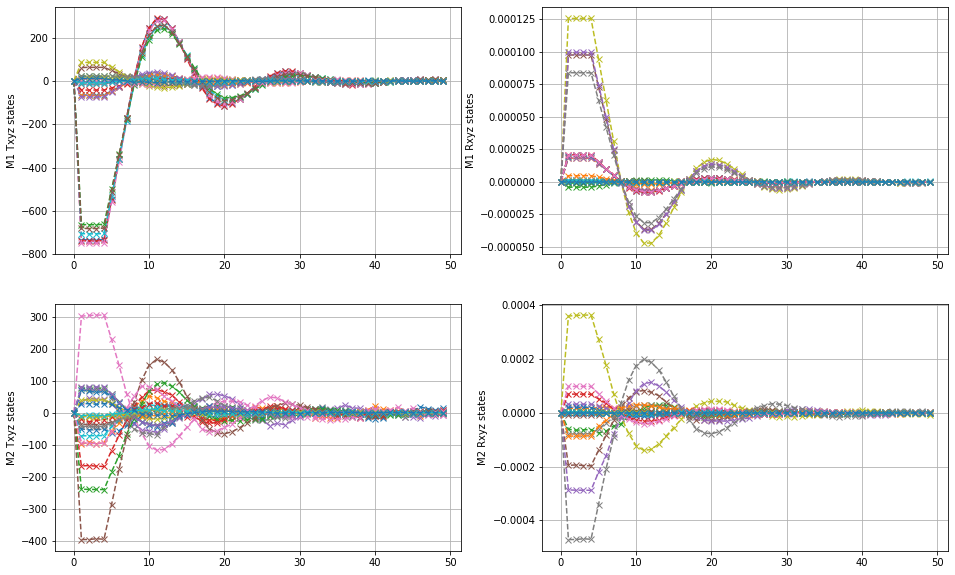

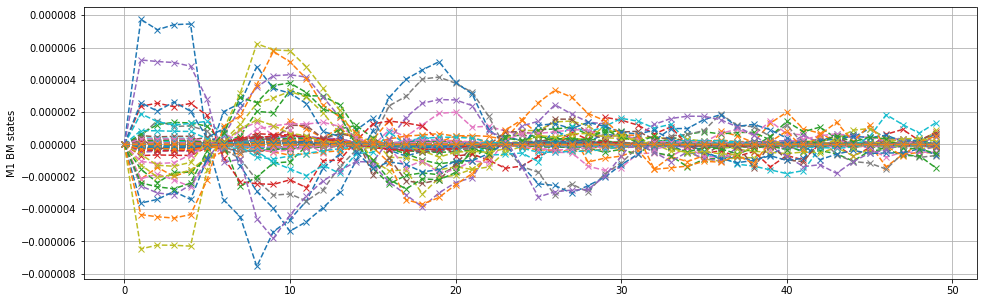

In [141]:
ptools.plot_states(sim.logs.entries['ReconstructorM']['x_hat'].timeSeries, n_bm)

### Baseline estimator results

Final values:
 WFE: [120.32427321] 
 [0.81886836 0.71771394 0.80300083 0.75114082 0.76690837 0.80283319
 0.18549545] 
PSSn: [0.99996617] 
sum of abs seg piston: 0.6568299681930512 
 [-0.05767361  0.15831404  0.03430005 -0.07000634 -0.2547539   0.0568892
 -0.02489283]


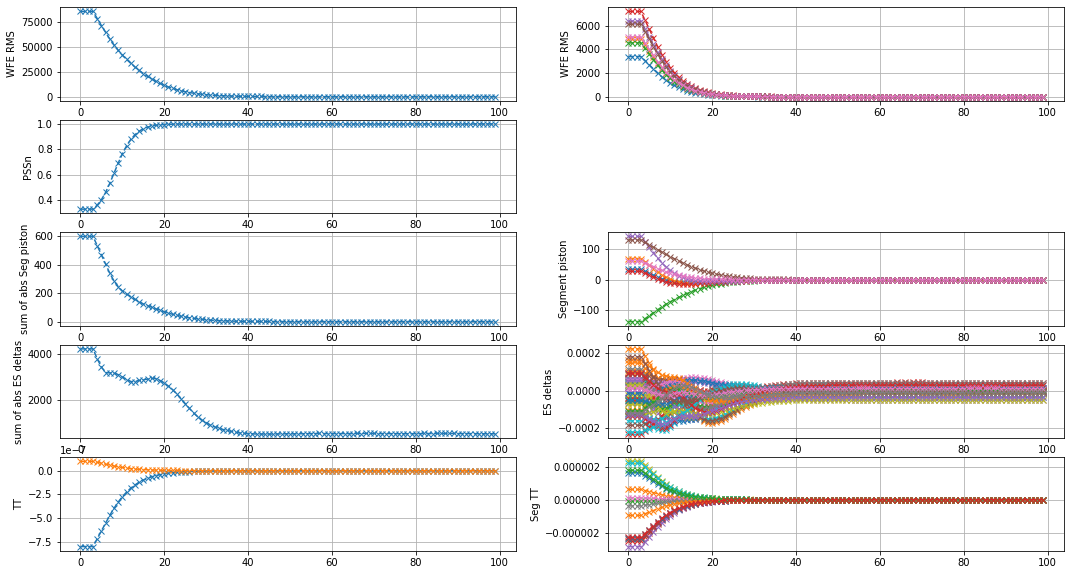

In [69]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

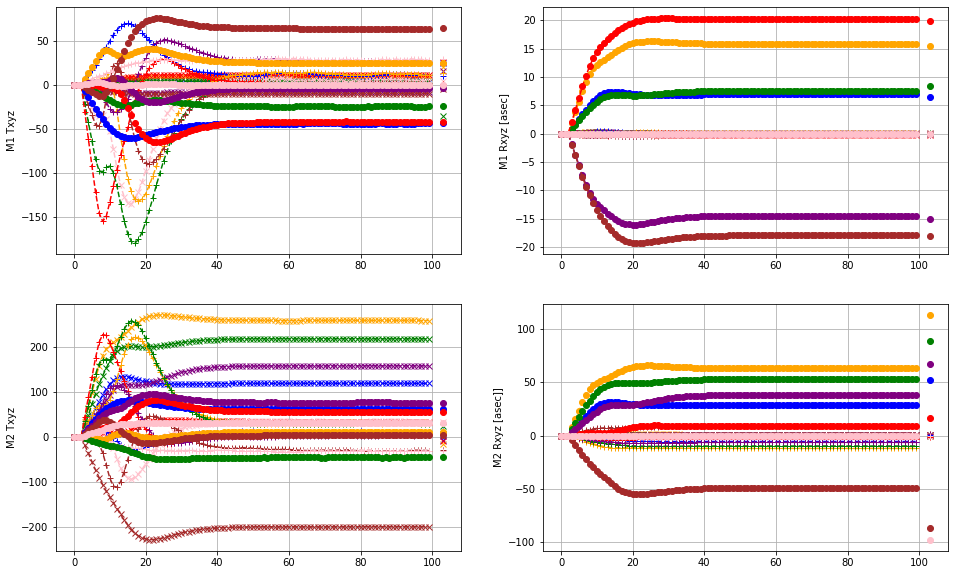

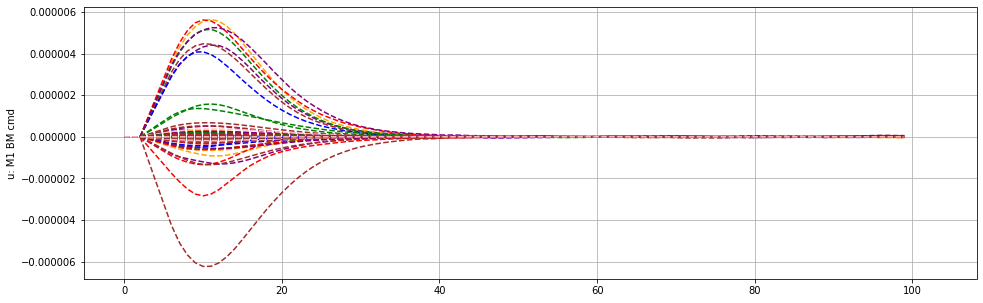

In [70]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Mismatch steady-state

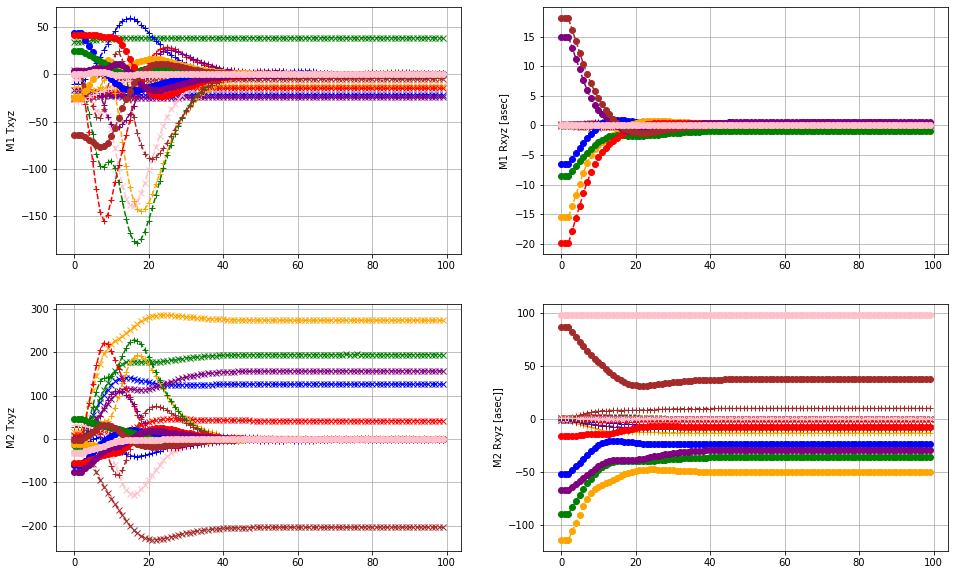

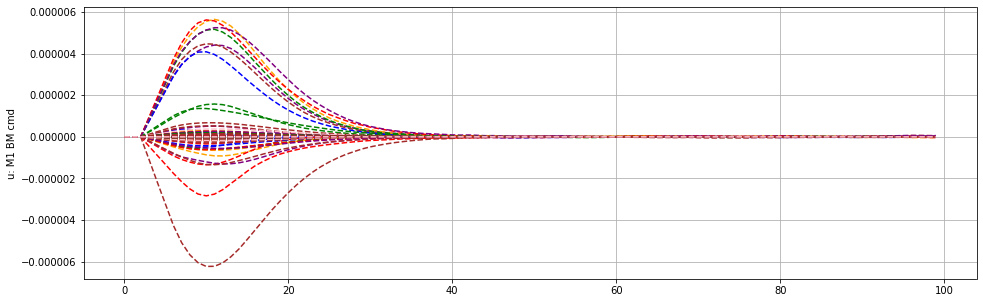

In [71]:
U = sim.logs.entries['AcO_controller']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Reconstructed states

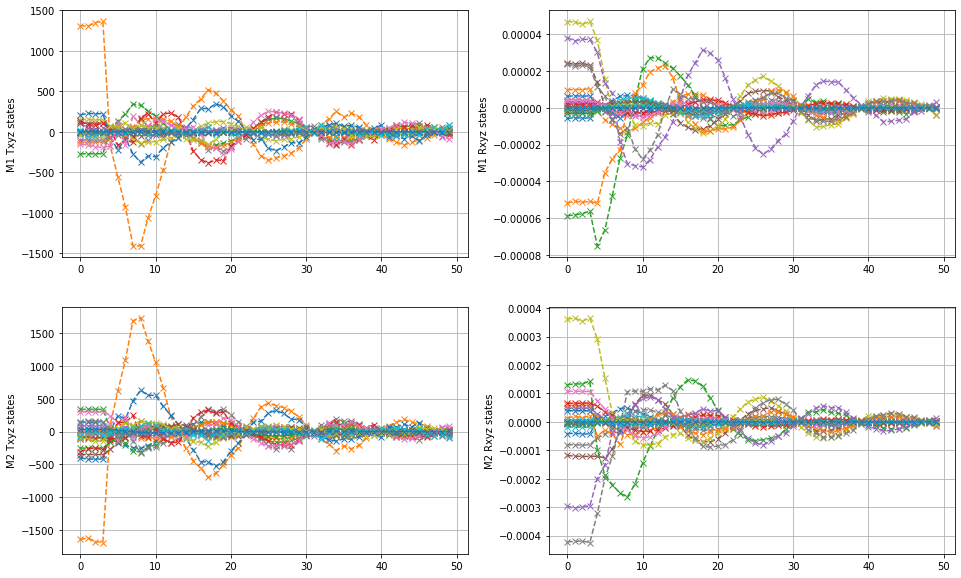

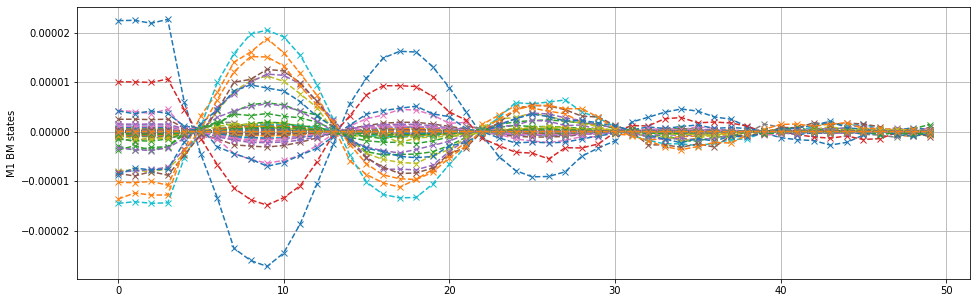

In [48]:
ptools.plot_states(sim.logs.entries['wfs48']['M12_RBM'].timeSeries, n_bm)